# Collage Model

**How is the collage model coming from?**  

A company marketing team is responsible for launching campaigns, designing the EDM, and advertising. They pay money for getting the copyright of images for the activities design. The images are not used anymore after the campaigns. It is such a waste! How could we reuse the images efficiently and creatively? The collage model is the way to go. I built the collage model which integrated with the CLIP model (https://github.com/openai/CLIP) of OPENAI can create a collage image depending on the images you have and the sentence you provide.

## Setup  
Here we will use Pytorch as the model framework.

In [1]:
!pip install -q torch
!pip install -q torchvision
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done


In [2]:
import os
import cv2
import clip
import math
import copy
import torch
from PIL import Image
from typing import Union
from torchvision.datasets import CIFAR100
import numpy as np
from matplotlib import pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

## Data Preparation

Prepare the images for collaging regarded to your description.  
\* You can add unrelated images or other sentences to test the performance of the model.

My target sentence is 'A dog is on the grass'. There are two basic types of images you need to prepare:
1. Background: grass(GT), sky, sea
2. Character: dog(GT), cat, bird

The source of sky, dog, cat, and bird images:
 https://www.needpix.com/

**If you use colab, remember to mount your google drive to get the images.**

In [4]:
TEXT = ['a dog is on the grass', 'a bird is in the sky', 'a cat is in the sea']
BACKGROUND_PATH = ['./drive/MyDrive/Collage_Model/background/' + i for i in os.listdir('./drive/MyDrive/Collage_Model/background/')]
CHARACTER_PATH = ['./drive/MyDrive/Collage_Model/character/' + i for i in os.listdir('./drive/MyDrive/Collage_Model/character/')]
print(BACKGROUND_PATH)
print(CHARACTER_PATH)

['./drive/MyDrive/Collage_Model/background/sky.jpg', './drive/MyDrive/Collage_Model/background/sea.png', './drive/MyDrive/Collage_Model/background/grass.png']
['./drive/MyDrive/Collage_Model/character/dog.png', './drive/MyDrive/Collage_Model/character/cat.png', './drive/MyDrive/Collage_Model/character/bird.png']


### Parameters

In [5]:
background_list = []
character_list = []
blending_list = []
RANDOM_TIMES = 2000 # How many collage images would be created

### Image Variation
This is a Class for doing image variation. It's including:
- Resize: resize the image
- Rotate: rotate the image
- Crop: crop the image
- Flip: flip the image to another side

This could increase the variablity of the collage image.

In [6]:
class IMG_VAR:
    def __init__(self, img:Union[str, np.ndarray]) -> object:
        """
        Create an image object for many variations.
            img: an image file path or a numpy array
        """
        if type(img) != str:
            self.img = img
        else:
            self.img = cv2.imread(img)
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]

    def show_img(self):
        """
        Show the object image.
        """
        plt.imshow(self.img)

    def resize(self, scale:float):
        """
        Reszie the image.
            scale: the scale for resize
        """
        self.img = cv2.resize(self.img, (int(self.width * scale), int(self.height * scale)))
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]

    def rotate(self, angle:int, scale:float=1.0):
        """
        Rotate the image.
            angle: the angle for rotate, the value must between 0 and 360
            scale: the scale for resize, default is 1.0
        """
        center = (self.width / 2, self.height / 2) # the center of the graph
        new_width = int((abs(math.cos(math.radians(angle))) * self.width + abs(math.sin(math.radians(angle))) * self.height) * scale) # cosθ * width + sinθ * height
        new_height = int((abs(math.cos(math.radians(angle))) * self.height + abs(math.sin(math.radians(angle))) * self.width) * scale) # sinθ * width + cosθ * height
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=scale)
        rotate_matrix +=  [[0, 0, (new_width - self.width) / 2], [0, 0, (new_height - self.height) / 2]] # translation
        self.img = cv2.warpAffine(src=self.img, M=rotate_matrix, dsize=(new_width, new_height))
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]

    def crop(self, width_bg:int, width_ed:int, height_bg:int, height_ed:int):
        """
        Crop the image.
            width_st: the beginning position of the width
            width_ed: the end position of the width
            height_st: the beginning position of the height
            height_ed: the end position of the height
        """
        self.img = self.img[height_bg:height_ed, width_bg:width_ed]
        self.height = self.img.shape[0]
        self.width = self.img.shape[1]

    def flip(self):
        """
        Flip the image.
        """
        self.img = cv2.flip(self.img, 0)

    def save(self, path):
        """
        Save the image to the path (must include file name)
        """
        Image.fromarray(self.img).save(path)

## Check out Images


### Original Image

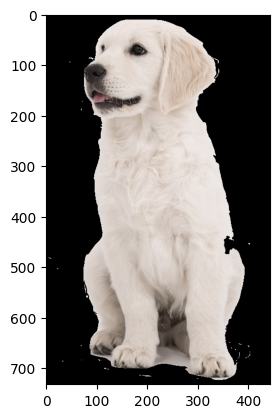

In [7]:
img_check = IMG_VAR(CHARACTER_PATH[0])
img_check.show_img()

### Resize

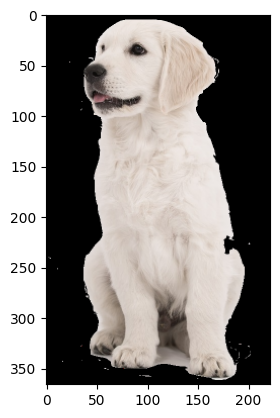

In [8]:
img_check.resize(0.5)
img_check.show_img()

### Rotate

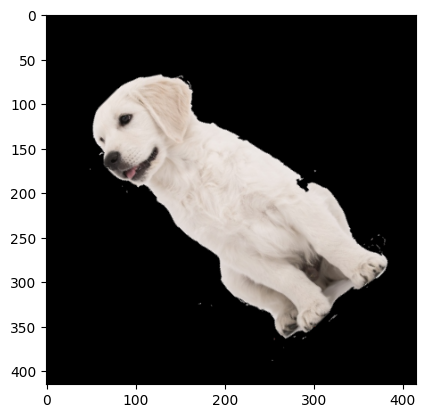

In [9]:
img_check.rotate(45)
img_check.show_img()

### Crop

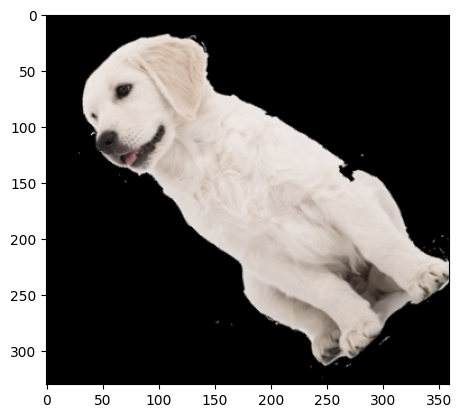

In [10]:
img_check.crop(20, 380, 50, 380)
img_check.show_img()

### Flip

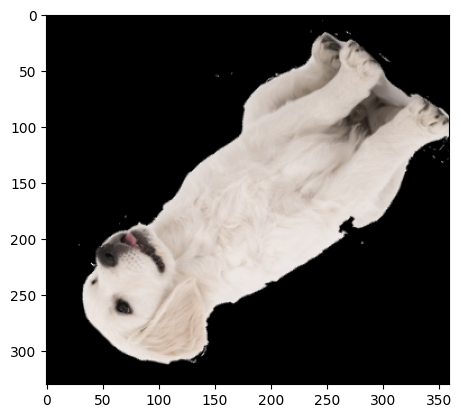

In [11]:
img_check.flip()
img_check.show_img()

### Save Image

In [12]:
img_check.save('./drive/MyDrive/Collage_Model/character/check_img.png')

## Build Collage Model
It is flexible to make your collage model setting.
The collage model embedded the `IMG_VAR` class. If you set the parameter `var=True`, the collage model will vary all the images automatically and randomly.

In this notebook, we won't create the variation of characters, but you must give it a try.  

In [13]:
def collage_image(background_list:list, character_list:list, background_size:list=[600, 800], resize_degree:float=1.0, var:bool=False, random:bool=False, random_size:list=[1], *args, **kwargs):
    """
    Collage images. The components will be chosen from the background_list and the character_list.
        background_list: background list
        character_list: character list
        background_size: if no background_list, it will create a white background according to the background_size, default is 600 x 800
        resize_degree: characters will be resized to the specific scale
        var: whether vary the character images randomly, resized characters between 0.1 and resize_degree scale
        random: whether the background and character images are selected randomly (background will only pick once, the characters will base on random_size)
        random_size: it is a list value. If the list contains only one value, it will pick the specific numbers, otherwise the picked numbers will randomly decide among the random_size
    """
    # create background
    if not BACKGROUND_PATH:
        background = create_white_img(background_size[0], background_size[1])
        background_list.append(IMG_VAR(background))
    else:
        for b_path in BACKGROUND_PATH:
            background_list.append(IMG_VAR(b_path))
    # create characters
    for ch_path in CHARACTER_PATH:
        character_list.append(IMG_VAR(ch_path))
    # create variation
    if var:
        for images in character_list:
            variation = []
            images.size_list = [math.ceil(i * 10 * resize_degree) / 10  for i in np.random.random(RANDOM_TIMES)] # ceil the number one decimal place, so the minimum will be 0.1
            images.angle_list = np.random.randint(0, 360, RANDOM_TIMES)
            images.flip_list = np.random.randint(0, 2, RANDOM_TIMES)
            for i in range(RANDOM_TIMES):
                tmp = copy.deepcopy(images)
                tmp.resize(images.size_list[i])
                tmp.rotate(images.angle_list[i])
                if images.flip_list[i]:
                    tmp.flip()
                variation.append(tmp.img)
            images.variation = variation
    elif resize_degree != 1:
        for img in character_list:
            img.resize(resize_degree)
    # build collage images
    for images in character_list:
        if not var and not random:
            images.mid_point = random_midpoint(background_list[0].img, images.img, random_num=RANDOM_TIMES)
        else:
            images.mid_point = np.zeros([RANDOM_TIMES, 2], dtype=int)
    for i in range(RANDOM_TIMES):
        if random:
            tmp_blending = np.random.choice(background_list, size=1)[0].img
            characters = np.random.choice(character_list, size=np.random.choice(random_size), replace=False)
        else:
            tmp_blending = background_list[0].img
            characters = character_list
        for images in characters:
            if not var and not random:
                tmp_blending = blending_img(tmp_blending, images.img, images.mid_point[i])
            elif var:
                images.mid_point[i] = random_midpoint(tmp_blending, images.variation[i], random_num=1)
                tmp_blending = blending_img(tmp_blending, images.variation[i], images.mid_point[i])
            else:
                images.mid_point[i] = random_midpoint(tmp_blending, images.img, random_num=1)
                tmp_blending = blending_img(tmp_blending, images.img, images.mid_point[i])
        blending_list.append(tmp_blending)

# create white background if no backgound provided
def create_white_img(height:int, width:int) -> np.ndarray:
    """
    Create a white image.
        height: the height of the image
        width: the width of the image
    """
    white_img = np.zeros([height, width, 3], dtype=np.uint8)
    white_img.fill(255)
    return white_img

# put a text to the image
def put_text(img, text, position=(0, 0), scale=1, color=(0, 0, 0), thick=3, font:str=None):
    """
    Put the text to the image.
        img: the target image
        text: the text would be put to the image
        position: the bottom-left corner position of the text in the image
        scale: text scale
        color: BGR
        thick: the thickness of the text
    """
    if not font:
        font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, text, position, font, scale, color, thick, cv2.LINE_AA)

def random_midpoint(img1:np.ndarray, img2:np.ndarray, specific:str=None, random_num:int=1) -> np.ndarray:
    """
    Create a random mid point according to the size of img1 and img2.\
    The mid point is for anchoring the img2 to the img1.
        img1: larger image
        img2: smaller image
        specific: top_left, bottom_left, top_right, bottom_right
        random_num: the number of random mid point
    """
    img1_rows, img1_cols = img1.shape[0], img1.shape[1] # large image
    img2_rows, img2_cols = img2.shape[0], img2.shape[1] # small image
    min_row, max_row = img2_rows//2, img1_rows + img2_rows//2 - img2_rows
    min_col, max_col = img2_cols//2, img1_cols + img2_cols//2 - img2_cols
    specific_position = {'top_left':[min_row, min_col], 'bottom_left':[max_row, min_col], 'top_right':[min_row, max_col], 'bottom_right':[max_row, max_col]}
    if specific:
        return [specific_position[specific]]
    random_midpoint = np.random.randint([min_row, min_col], [max_row, max_col], size= [random_num, 2])
    return random_midpoint

def blending_img(img1:np.ndarray, img2:np.ndarray, middle_point:Union[list, np.ndarray]) -> np.ndarray:
    """
    Blend the two images.\
    Anchor the img2 to the img1.
        img1: larger image
        img2: smaller image
        middle_point: the position where the img2 will be anchored
    """
    rows, cols = img2.shape[0], img2.shape[1]
    roi = img1[middle_point[0] - rows//2: middle_point[0] - rows//2 + rows  , middle_point[1] - cols//2: middle_point[1] - cols//2 + cols]

    img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)

    mask_inverse = cv2.bitwise_not(mask)
    img1_background = cv2.bitwise_and(roi, roi, mask=mask_inverse)
    img2_figure = cv2.bitwise_and(img2, img2, mask=mask)
    tmp_blending_img = cv2.add(img1_background, img2_figure)
    blending_img = img1.copy()
    blending_img[middle_point[0] - rows//2: middle_point[0] - rows//2 + rows  , middle_point[1] - cols//2: middle_point[1] - cols//2 + cols] = tmp_blending_img
    return blending_img

def create_variation(images:IMG_VAR, scale:float, angle:int, flip:bool):
    """
    Variation the IMG_VAR object, include: resizing, rotatation, flipping.\
    The variation result will be appended to the variation attribute of the object.
        images: IMG_VAR object
        scale: the scale for resizing
        angle: the angle for rotation
        flip: True or False, 1 or 0
    """
    tmp = copy.deepcopy(images)
    tmp.resize(scale)
    tmp.rotate(angle)
    if flip:
        tmp.flip()
    images.variation = tmp.img

### 1.Create Collage Images
The collage images will be stored in the `blending_list`.

2000


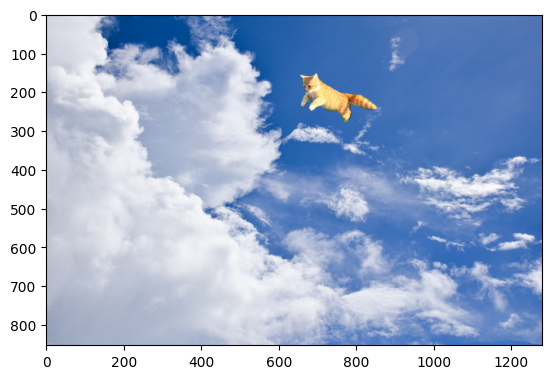

In [14]:
collage_image(background_list, character_list, resize_degree=0.3, random=True)

print(len(blending_list))

plt.imshow(blending_list[0])

### 2.Data Transformation

Transform the format of images, and sentences to fit the CLIP model.

In [15]:
# Transform the images for CLIP
image = torch.cat([preprocess(Image.fromarray(blending_list[i])).unsqueeze(0).to(device) for i in range(RANDOM_TIMES)])

# Tokenize the description
text = clip.tokenize(TEXT).to(device)

### 3.Fit the CLIP Model

In [16]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

### 4.Results

In [17]:
def show_result(n:int):
    """
    Show the n index blending result.
    """
    for text, prob in zip(TEXT, probs[n]):
        print(f'{text}: {round(prob * 100, 2)}')
    plt.imshow(blending_list[n])

for txt, img in zip(TEXT, np.argmax(probs, axis =0)):
    print(f'Maximum Probability of {txt} is {img} image')

Maximum Probability of a dog is on the grass is 66 image
Maximum Probability of a bird is in the sky is 20 image
Maximum Probability of a cat is in the sea is 311 image


a dog is on the grass: 99.66
a bird is in the sky: 0.07
a cat is in the sea: 0.25


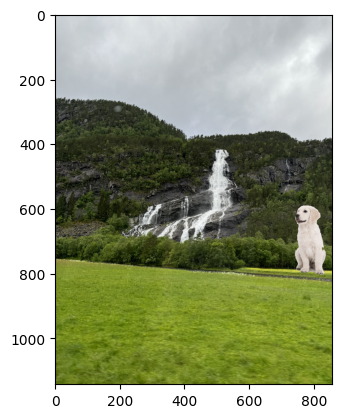

In [18]:
show_result(66)

a dog is on the grass: 0.01
a bird is in the sky: 100.0
a cat is in the sea: 0.01


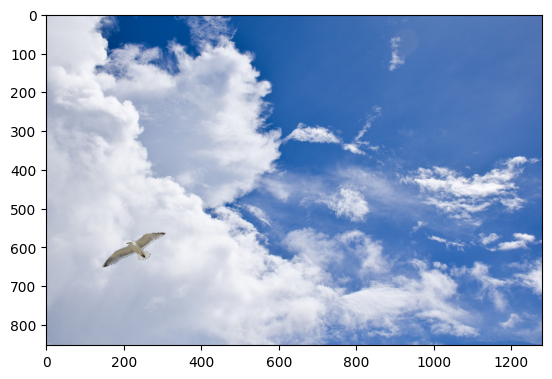

In [19]:
show_result(20)

a dog is on the grass: 0.02
a bird is in the sky: 0.03
a cat is in the sea: 99.95


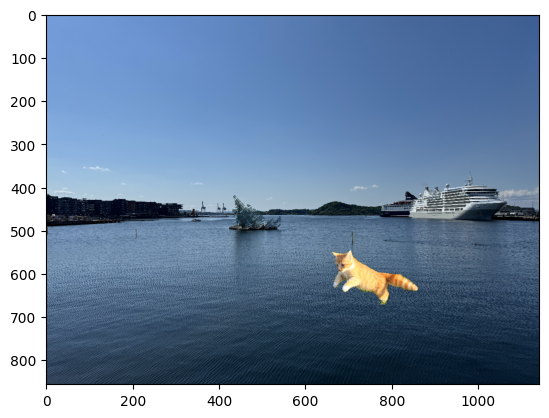

In [20]:
show_result(311)